In [48]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from filterpy.kalman import JulierSigmaPoints
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise
import math
from numpy.random import randn

In [49]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

In [50]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft"""
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return F @ x
    
def cv_UKF(fx, hx, R_std):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
    kf = UKF(4, len(R_std), dt, fx=fx, hx=hx, points=points)

    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.R = np.diag(R_std)
    kf.R = kf.R @ kf.R  # square to get variance
    kf.x = np.array([0., 90., 1100., 0.])
    kf.P = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf

In [51]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

In [141]:
p_history = []
np.set_printoptions(precision=3)
dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos
np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)

kf_cv = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 300 + dt, dt)
xs, ys = [], []
for i, t in enumerate(time):
#     if t >= 60:
    ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    
    kf_cv.predict()
    if i <= 5:
        kf_cv.update([r[0], r[1]])
    ys.append(ac.pos.copy())
    xs.append(kf_cv.x)
    print(f'{i}- final covariance', kf_cv.P.diagonal())
    p_history.append(kf_cv.P.diagonal())

# plot_altitude(xs, time, ys)
# print(f'Actual altitude: {ac.pos[1]:.1f}')
# print(f'UKF altitude   : {xs[-1][2]:.1f}')

0- final covariance [ 129.809    9.892 2881.127    9.872]
1- final covariance [62.607  7.232 42.273 10.333]
2- final covariance [60.496  4.24  47.544  5.65 ]
3- final covariance [60.388  2.87  69.173  3.603]
4- final covariance [59.423  2.293 89.566  2.893]
5- final covariance [ 57.918   2.041 110.184   2.699]
6- final covariance [123.11    2.941 216.367   3.599]
7- final covariance [241.235   3.841 387.332   4.499]
8- final covariance [428.495   4.741 639.281   5.399]
9- final covariance [701.09    5.641 988.412   6.299]
10- final covariance [1075.218    6.541 1450.926    7.199]
11- final covariance [1567.081    7.441 2043.023    8.099]
12- final covariance [2192.879    8.341 2780.902    8.999]
13- final covariance [2968.81     9.241 3680.765    9.899]
14- final covariance [3911.076   10.141 4758.81    10.799]
15- final covariance [5035.876   11.041 6031.238   11.699]
16- final covariance [6359.41    11.941 7514.249   12.599]
17- final covariance [7897.879   12.841 9224.043   13.499]


In [142]:
xs = np.array(xs)
ys = np.array(ys)
p_history = np.array(p_history)
# xs[:, [0,2]]
# xs[:,[2]] -  ys[:,[1]]


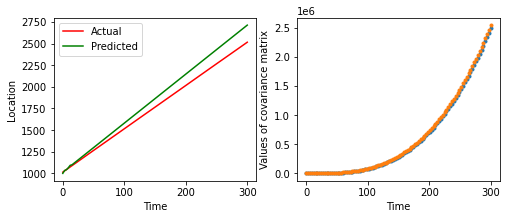

In [143]:
fig, ax = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (8, 3)
ax[0].plot(time, ys[:,1], c='r', label="Actual")
ax[0].plot(time, xs[:,2], c='g', label="Predicted")
ax[0].legend()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Location")
ax[1].scatter(time,p_history[:,0], marker='.')
ax[1].scatter(time,p_history[:,2], marker='.')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Values of covariance matrix")
plt.savefig("ukf_deviation.pdf", bbox_inches='tight')
plt.show()

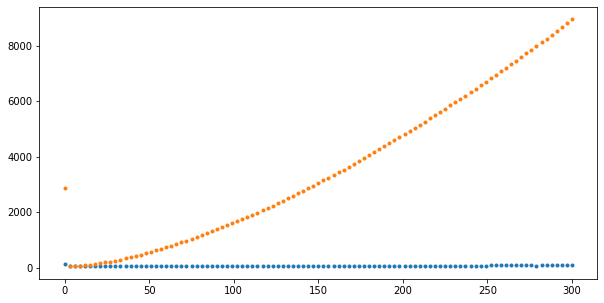

In [101]:
plt.scatter(time,p_history[:,0], marker='.')
# plt.scatter(time,p_history[:,1], marker='.')
plt.scatter(time,p_history[:,2], marker='.')
# plt.scatter(time,p_history[:,3], marker='.')
plt.show()